## CROP RECOMMENDATION MODEL DEVELOPMENT

Some of our selected features from this dataset and their descriptions:

* `Nitrogen` : value of Nitrogen rate
* `Potassium` : value of Potassium rate
* `Phosphorus` : value of Phosphorus
* `Rainfall` : rainfall rate
* `Temperature` : rate of Temperature
* `Crop` : various crop names

In [1]:
# Importing the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(font_scale=1.5,style="darkgrid")
sns.set_palette(['#ff826e', 'red'])
sns.set(rc={"axes.facecolor":'#faded9'})
%matplotlib inline

import pickle
import warnings
warnings.filterwarnings('ignore')

### Load the dataset

In [2]:
df = pd.read_csv('.Crop_recommendation_NEW_dataset.csv')
df.head()

,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop
0,100,60,40,6.0,500,15,Wheat
1,105,60,40,6.0,500,15,Wheat
2,110,60,40,6.0,500,15,Wheat
3,115,60,40,6.0,500,15,Wheat
4,120,60,40,6.0,500,15,Wheat


### Data preprocessing

In [11]:
# Check the summary information of our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2750 non-null   int64  
 1   Phosphorus   2750 non-null   int64  
 2   Potassium    2750 non-null   int64  
 3   pH           2750 non-null   float64
 4   Rainfall     2750 non-null   int64  
 5   Temperature  2750 non-null   int64  
 6   Crop         2750 non-null   object 
dtypes: float64(1), int64(5), object(1)
memory usage: 150.5+ KB


In [3]:
# Check mathematical summary of our dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Nitrogen,2750.0,107.278182,34.368238,20.0,85.0,120.0,135.0,150.0
Phosphorus,2750.0,59.994545,14.554434,15.0,50.0,60.0,70.0,90.0
Potassium,2750.0,71.354545,37.543133,20.0,45.0,55.0,100.0,150.0
pH,2750.0,6.723636,0.599795,5.5,6.5,6.5,7.0,8.5
Rainfall,2750.0,849.745455,273.940847,300.0,600.0,800.0,1000.0,1500.0
Temperature,2750.0,24.885455,5.982542,15.0,20.0,25.0,30.0,40.0


In [4]:
# Check the size of our dataset
df.shape

(2750, 7)

In [5]:
# Check whether there is duplicated values in our dataset
df.duplicated().sum()

69

As we can see in the above senario, we found `69` duplicated values which can lead to data leakage in our model. To avoid that we need to remove them.

In [6]:
# Now we can remove duplicated values in our dataset
df = df.drop_duplicates()

# We can check the size of our dataset after removing the duplicated values
df.shape

(2681, 7)

In [7]:
# Let's split feature and target label
X = df.drop('Crop',axis=1)
y = df['Crop']

In [8]:
# Let's also check whether there are outliers in our dataset
def find_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outlier = df[(df[feature]<lower_bound) | (df[feature]>upper_bound)]
    return outlier

for feature in X.select_dtypes(['int','float']).columns:
    outlier = find_outliers(X,feature)
    print(f"The {feature} has {len(outlier)} potential outliers")

The Nitrogen has 0 potential outliers
The Phosphorus has 6 potential outliers
The Potassium has 0 potential outliers
The pH has 147 potential outliers
The Rainfall has 0 potential outliers
The Temperature has 0 potential outliers


From the above senario, we can see that the features `Phosphorus` and `pH`. To avoid bad results of our model, we can solve this issue by fitting them in range of other data of the same feature.

In [9]:
# Let's remove those outliers appeared in our dataset
outlier_features = ['Phosphorus','pH']
def remove_outliers(df,feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df[feature] = np.where(df[feature]<lower_bound,lower_bound,np.where(df[feature]>upper_bound,
                                                                       upper_bound,df[feature]))

for feature in outlier_features:
    remove_outliers(X,feature)

# Now we can whether the outliers are removed
for feature in X.select_dtypes(['int','float']).columns:
    outlier = find_outliers(X,feature)
    print(f"The {feature} has {len(outlier)} potential outliers")

The Nitrogen has 0 potential outliers
The Phosphorus has 0 potential outliers
The Potassium has 0 potential outliers
The pH has 0 potential outliers
The Rainfall has 0 potential outliers
The Temperature has 0 potential outliers


In [10]:
# Let's also check our target label for the balance of class labels
df['Crop'].value_counts()

Crop
Sugarcane    1010
Wheat         807
Maize         336
Rice          309
Groundnut     174
Soybean        45
Name: count, dtype: int64

As we can see, there is imbalance in class labels. When this issue arise in the dataset, can lead to difficulties of one class which has more data than others to dominate in prediction results, which is not accurate enough to our prediction purpose. To avoid this we can oversample the training dataset for making good model learning results.
* The reason why we oversample only train dataset is to avoid the data leakage (to predict with the data already seen by model)

In [11]:
# Let's split dataset into train and test datasets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [12]:
# Let's oversample the train dataset
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Before smote: ',Counter(y_train))
# Perform SMOTE
smote=SMOTE(random_state=42)
# Oversample the train dataset
X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

# The numbers after SMOTE
print("After smote:", Counter(y_train_smote))


Before smote:  Counter({'Sugarcane': 701, 'Wheat': 561, 'Maize': 231, 'Rice': 227, 'Groundnut': 124, 'Soybean': 32})
After smote: Counter({'Sugarcane': 701, 'Wheat': 701, 'Rice': 701, 'Maize': 701, 'Soybean': 701, 'Groundnut': 701})


In [18]:
X_train_smote.duplicated().sum()

398

In [19]:
train = X_train_smote.assign(Crop=y_train_smote)
train.head()

,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop
0,150,60.0,65,6.5,1200,25,Sugarcane
1,70,45.0,40,6.5,500,15,Wheat
2,115,60.0,55,6.5,900,35,Rice
3,125,65.0,75,7.0,1200,35,Sugarcane
4,135,65.0,50,6.0,500,20,Maize


In [20]:
train = train.drop_duplicates()

In [21]:
train['Crop'].value_counts()

Crop
Sugarcane    701
Wheat        694
Maize        649
Groundnut    636
Rice         615
Soybean      513
Name: count, dtype: int64

In [22]:
train.duplicated().sum()

0

In [24]:
X_test.assign(Crop=y_test).head()

,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop
795,105,45.0,40,6.5,900,20,Wheat
1744,80,60.0,100,7.5,1200,20,Sugarcane
1571,30,45.0,25,6.5,700,30,Groundnut
1911,140,60.0,80,6.5,1200,20,Sugarcane
211,105,50.0,40,6.5,1000,25,Wheat


In [17]:
df.dtypes

Nitrogen         int64
Phosphorus       int64
Potassium        int64
pH             float64
Rainfall         int64
Temperature      int64
Crop            object
dtype: object

The reason why we repeated `duplication checking` is to ensure that no duplicate values occured in our dataset after oversampling the training dataset and we see now the dataset is clean and class label somehow balanced.

In [29]:
# Here we split again our train dataset
X_train_smote,y_train_smote = train.drop('Crop',axis=1), train['Crop']

## Exploratory Data Analysis (EDA)

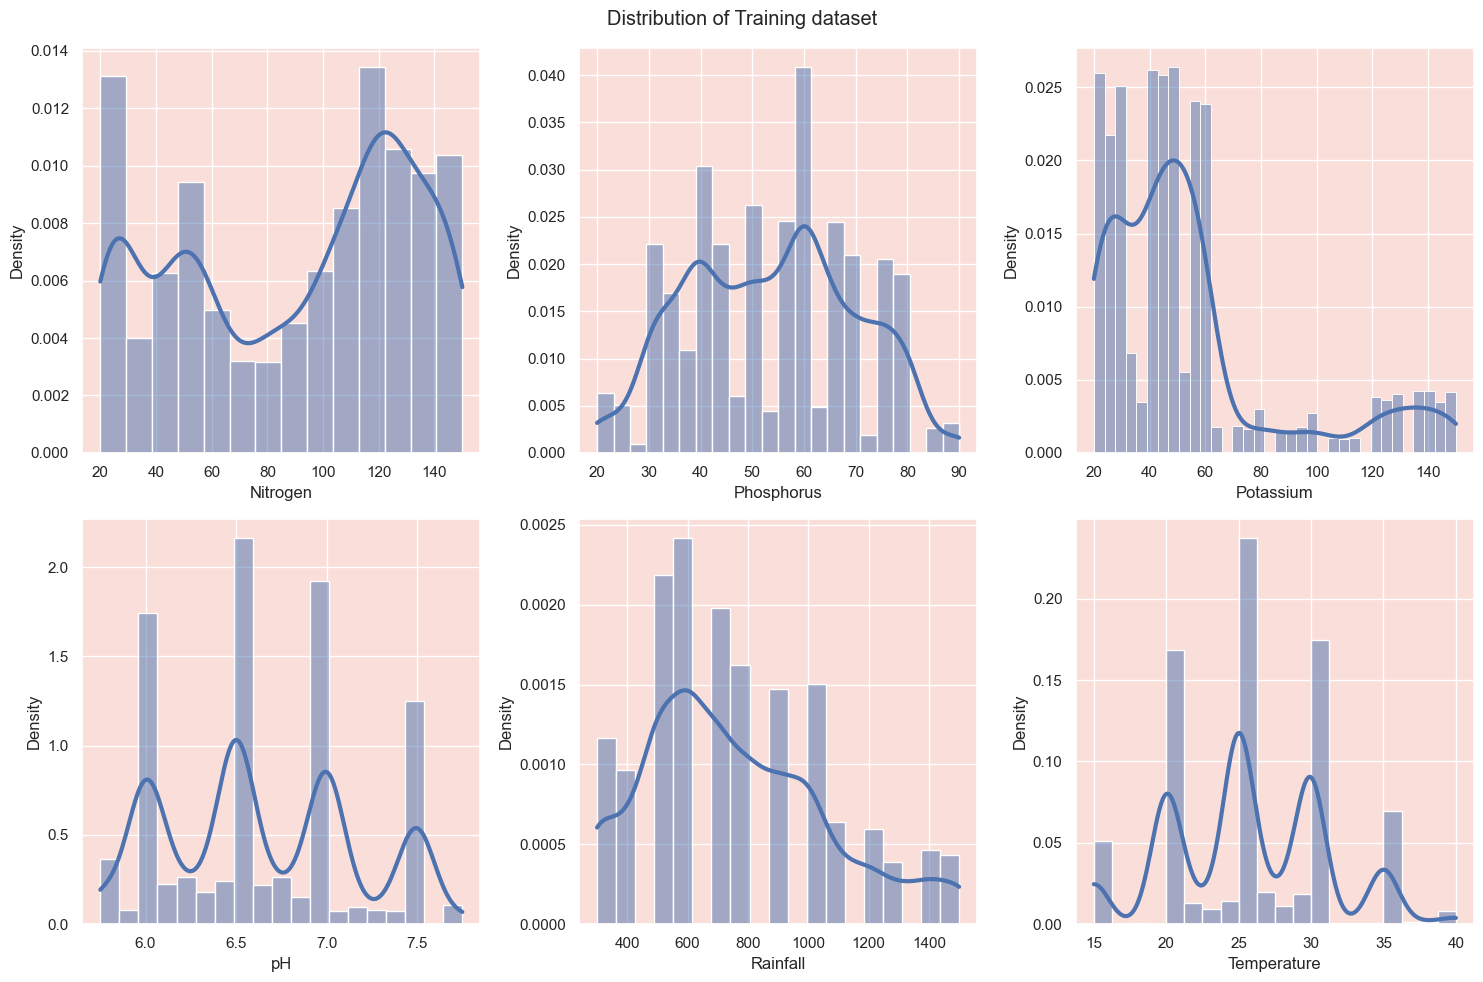

In [30]:
# Check the normal distribution of our data
fig, ax = plt.subplots(2,3,figsize=(15,10))
for i,col in enumerate(X_train_smote.columns):
    x = i//3
    y = i%3
    sns.histplot(data=X_train_smote,x=X_train_smote[col],ax=ax[x,y],stat='density',
                 fill=True,kde=True,line_kws={'lw':3})
fig.suptitle("Distribution of Training dataset")
fig.tight_layout();

The above graphs demonstrate the litle normality in dataset some of the features. Before scaling them we may try the agorithms requires no scaling to check their peformance

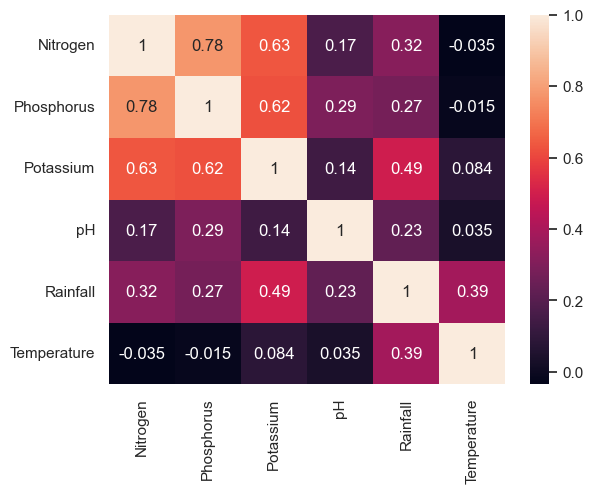

In [113]:
#  Let's also check the correlation between features
sns.heatmap(X_train_smote.corr(),annot=True);

As an intepretation for the above diagram, there is no much correlation between features except for `Nitrogen` and `Phosporus` which have high correlation compared to other features in our dataset.
* The reason why we cannot remove any of both correlated feature is: Based on the abstract of `Zhen’an Yang` which says that "As essential nutrients for plant growth and development, the balance of `nitrogen (N)` and `phosphorus (P)` between soils and plants is a key component to ecosystem stability". That's why it is essential to remain with both features for better recommendation of crop to be grown in the soil.

In [31]:
y_train_smote.value_counts()

Crop
Sugarcane    701
Wheat        694
Maize        649
Groundnut    636
Rice         615
Soybean      513
Name: count, dtype: int64

## Model Development

In [32]:
# Let's start for the random classifier model to evaluate it's result
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_smote,y_train_smote)

RandomForestClassifier()

In [33]:
# Let's make predictions
y_pred = clf.predict(X_test)
y_pred[0]

'Wheat'

## Model Evaluation

In [34]:
from sklearn.metrics import classification_report,accuracy_score,ConfusionMatrixDisplay

# Let's start by checking whether there is overfitting in our model performance
print("Training accuracy: ",clf.score(X_train_smote,y_train_smote))
print("Test performance accuracy: ",round(clf.score(X_test,y_test),2))

Training accuracy:  1.0
Test performance accuracy:  0.99


In [36]:
# Let's evaluate the accuracy score between y_test and y_pred
score = accuracy_score(y_test,y_pred)
print("The model accuracy score: ",round(score,2)*100,"%")

The model accuracy score:  99.0 %


In [38]:
# Let's try the classification report of our model
score2 = classification_report(y_test,y_pred)
print(score2)

              precision    recall  f1-score   support

   Groundnut       1.00      1.00      1.00        50
       Maize       0.98      0.99      0.99       105
        Rice       1.00      0.98      0.99        82
     Soybean       1.00      1.00      1.00        13
   Sugarcane       1.00      1.00      1.00       309
       Wheat       0.99      0.99      0.99       246

    accuracy                           0.99       805
   macro avg       0.99      0.99      0.99       805
weighted avg       0.99      0.99      0.99       805



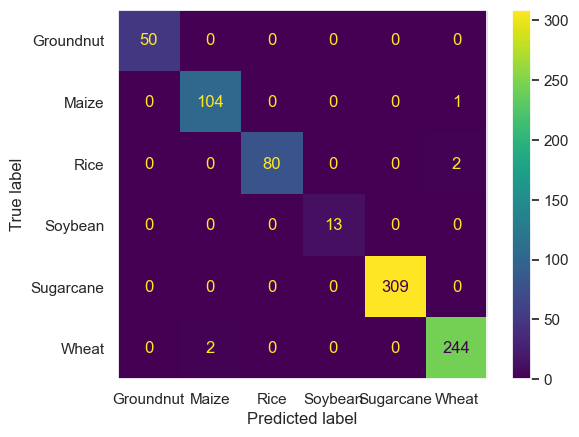

In [45]:
sns.set(style='dark')
ConfusionMatrixDisplay.from_predictions(y_test,y_pred);

From above model performance evaluation, indicates that our model is able to predict the new unseen data at the accuracy of `99%`. Which is good to integrate into our system to review it's performance.

In [39]:
# At this point we can save our model
pickle.dump(clf,open("crop_recommendation_model.pkl","wb"))

In [41]:
# Load saved model
model = pickle.load(open("crop_recommendation_model.pkl","rb"))
model.score(X_test,y_test)

0.9937888198757764

In [46]:
y_train_smote.value_counts()

Crop
Sugarcane    701
Wheat        694
Maize        649
Groundnut    636
Rice         615
Soybean      513
Name: count, dtype: int64

In [49]:
pred = model.predict([[150,60.0,65,6.5,1200,25]])
pred.tolist()[0]

'Sugarcane'